In [3]:
import pandas as pd
import numpy as np
import re
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_theme(style='whitegrid')

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_hub as hub

# Load the Universal Sentence Encoder module
module_url = 'https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/large/versions/2'
embed = hub.load(module_url)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jirayuwat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jirayuwat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
LABEL_LIST = ['CE','ENV','BME','PE','METAL','ME','EE','CPE','OPTIC','NANO','CHE','MATENG','AGRI','EDU','IE','SAFETY','MATH','MATSCI']

In [5]:
df = pd.read_json(r'../data/train_for_student.json').transpose()

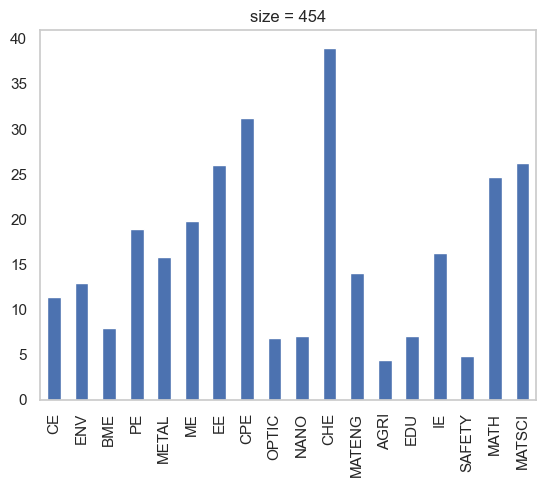

In [6]:
for label in LABEL_LIST:
    df[label] = df['Classes'].apply(lambda x: 1 if label in x else 0)

(100*df[LABEL_LIST].sum()/len(df)).plot(kind='bar')
plt.title(f'size = {len(df)}')
plt.grid()

In [7]:
df

,Title,Abstract,Classes,CE,ENV,BME,PE,METAL,ME,EE,...,OPTIC,NANO,CHE,MATENG,AGRI,EDU,IE,SAFETY,MATH,MATSCI
1,Activated carbon derived from bacterial cellul...,© 2019 Elsevier B.V.Activated carbon derived f...,"[CHE, MATENG]",0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
2,The algorithm of static hand gesture recogniti...,© Springer International Publishing AG 2018.Te...,[CPE],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Alternative Redundant Residue Number System Co...,© 2018 IEEE.Residue number system (RNS) is a n...,[EE],0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Comparative study of wax inhibitor performance...,© Published under licence by IOP Publishing Lt...,"[PE, ME, CHE]",0,0,0,1,0,1,0,...,0,0,1,0,0,0,0,0,0,0
5,Undrained lower bound solutions for end bearin...,"© 2019 John Wiley & Sons, Ltd.The undrained be...","[CE, MATSCI]",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,A portable USB-controlled potentiostat for pap...,© 2018 IEEEThis paper presents a portable and ...,"[CPE, CHE]",0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
451,Literature reviews on applying artificial inte...,Copyright © 2019 for this paper by its authors...,"[CPE, EDU]",0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
452,A multi-parameterized water quality prediction...,© 2019 The authors and IOS Press. All rights r...,"[ENV, EE, CHE]",0,1,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
453,Semantic Segmentation on Medium-Resolution Sat...,© 2018 IEEE.Semantic Segmentation is a fundame...,"[EE, CPE, OPTIC, EDU]",0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0


In [8]:
df['num_class'] = df['Classes'].apply(lambda x: len(x))

<Axes: xlabel='num_class'>

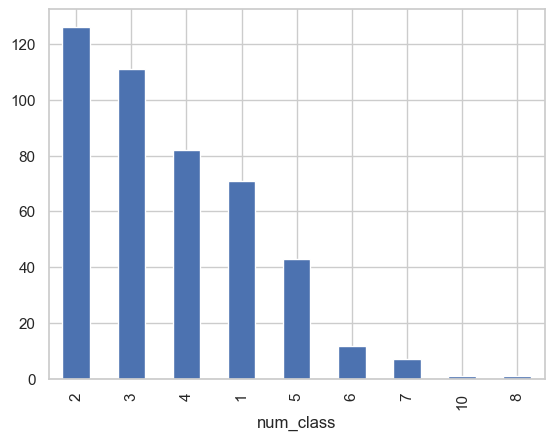

In [9]:
df['num_class'].value_counts().plot(kind='bar')

<Figure size 1000x1000 with 0 Axes>

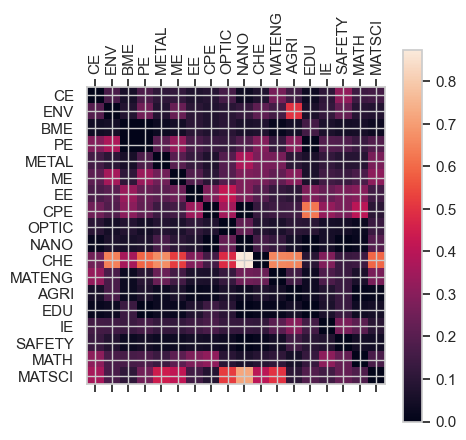

In [10]:
matrix = np.zeros((len(LABEL_LIST),len(LABEL_LIST)))
for i in range(len(LABEL_LIST)):
    for j in range(len(LABEL_LIST)):
        if i == j:
            continue
        matrix[i,j] = (df[LABEL_LIST[i]] & df[LABEL_LIST[j]]).sum() / df[LABEL_LIST[j]].sum()

plt.figure(figsize=(10, 10))
plt.matshow(matrix)
plt.colorbar()
plt.xticks(range(len(LABEL_LIST)), LABEL_LIST, rotation=90)
plt.yticks(range(len(LABEL_LIST)), LABEL_LIST)
plt.show()

In [11]:
df['Title'].apply(lambda x: len(x.split())).sum(), df['Abstract'].apply(lambda x: len(x.split())).sum()

(5881, 81331)

In [12]:
def clean_and_tokenize(df, is_test=False):
    df = df.copy()

    df['Text'] = df['Title'] + " " + df['Abstract']

    df.drop(columns=['Title', 'Abstract'], inplace=True)

    # lower case
    # df['Text'] = df['Text'].apply(lambda x: x.lower())

    # remove special characters
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x))

    # remove text
    target_text = ['published', 'licence', 'iop', 'publishing', 'ltd', 'using', 'ieee', 'association', 'elsevier', 'springer', 'wal', 'system', 'thailand', 'john' ,'wiley', 'sons', 'international', 'Publications']
    df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in target_text]))

    # stemmer
    lemmatizer = WordNetLemmatizer()
    df['Text'] = df['Text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

    # tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    df['Text'] = df['Text'].apply(lambda x: [word for word in word_tokenize(x)  if word.lower() not in stop_words])

    # word cloud
    all_words = [word for tokens in df['Text'] for word in tokens]
    wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(all_words))
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Top words after clean and tokenize')
    plt.axis('off')
    plt.show()

    return df

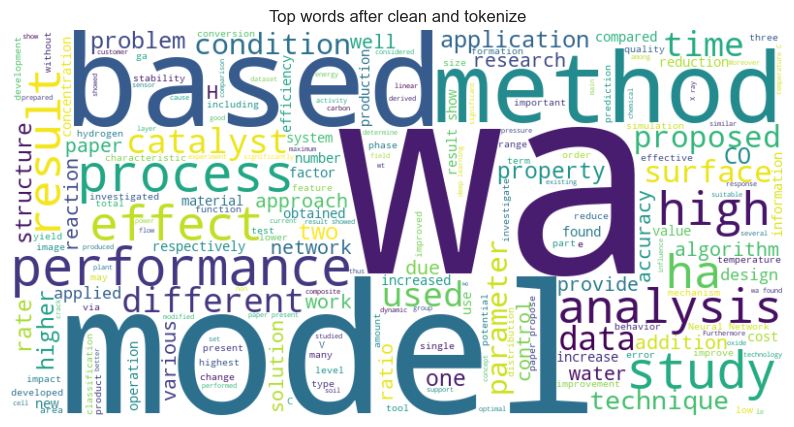

,Classes,CE,ENV,BME,PE,METAL,ME,EE,CPE,OPTIC,...,CHE,MATENG,AGRI,EDU,IE,SAFETY,MATH,MATSCI,num_class,Text
1,"[CHE, MATENG]",0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,2,"[Activated, carbon, derived, bacterial, cellul..."
2,[CPE],0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,"[algorithm, static, hand, gesture, recognition..."
3,[EE],0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,"[Alternative, Redundant, Residue, Number, Cons..."
4,"[PE, ME, CHE]",0,0,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,3,"[Comparative, study, wax, inhibitor, performan..."
5,"[CE, MATSCI]",1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,2,"[Undrained, lower, bound, solution, end, beari..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,"[CPE, CHE]",0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,2,"[portable, USB, controlled, potentiostat, pape..."
451,"[CPE, EDU]",0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,2,"[Literature, review, applying, artificial, int..."
452,"[ENV, EE, CHE]",0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,3,"[multi, parameterized, water, quality, predict..."
453,"[EE, CPE, OPTIC, EDU]",0,0,0,0,0,0,1,1,1,...,0,0,0,1,0,0,0,0,4,"[Semantic, Segmentation, Medium, Resolution, S..."


In [13]:
clean_and_tokenize(df)

In [16]:
df

,Title,Abstract,Classes,CE,ENV,BME,PE,METAL,ME,EE,...,NANO,CHE,MATENG,AGRI,EDU,IE,SAFETY,MATH,MATSCI,num_class
1,Activated carbon derived from bacterial cellul...,© 2019 Elsevier B.V.Activated carbon derived f...,"[CHE, MATENG]",0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,2
2,The algorithm of static hand gesture recogniti...,© Springer International Publishing AG 2018.Te...,[CPE],0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,Alternative Redundant Residue Number System Co...,© 2018 IEEE.Residue number system (RNS) is a n...,[EE],0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
4,Comparative study of wax inhibitor performance...,© Published under licence by IOP Publishing Lt...,"[PE, ME, CHE]",0,0,0,1,0,1,0,...,0,1,0,0,0,0,0,0,0,3
5,Undrained lower bound solutions for end bearin...,"© 2019 John Wiley & Sons, Ltd.The undrained be...","[CE, MATSCI]",1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
450,A portable USB-controlled potentiostat for pap...,© 2018 IEEEThis paper presents a portable and ...,"[CPE, CHE]",0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,2
451,Literature reviews on applying artificial inte...,Copyright © 2019 for this paper by its authors...,"[CPE, EDU]",0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,2
452,A multi-parameterized water quality prediction...,© 2019 The authors and IOS Press. All rights r...,"[ENV, EE, CHE]",0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,3
453,Semantic Segmentation on Medium-Resolution Sat...,© 2018 IEEE.Semantic Segmentation is a fundame...,"[EE, CPE, OPTIC, EDU]",0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,4


In [33]:
publisher_list = ['IOP Publishing',
                  'IEEE', 'Elsevier', 
                  'Springer International Publishing', 
                  'John Wiley & Sons', 
                  'Association for Computer Machinery', 
                  'Nature Singapore Pte Ltd.', 
                  'KSME', 
                  'JSME', 
                  'American Chemical Society']

df['Publisher'] = df['Abstract'].apply(lambda x: [publisher for publisher in publisher_list if publisher in x]).apply(lambda x: x[0] if len(x) > 0 else 'Other')

<Figure size 1000x1000 with 0 Axes>

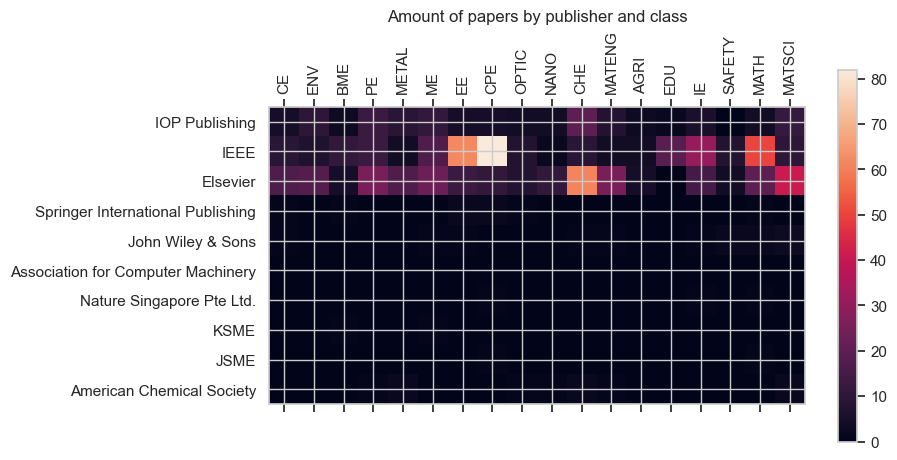

In [46]:
count_matrix = np.zeros((len(publisher_list), len(LABEL_LIST)))
for i in range(len(LABEL_LIST)):
    for j in range(len(publisher_list)):
        count_matrix[j,i] = (df[LABEL_LIST[i]] & (df['Publisher'] == publisher_list[j])).sum()

plt.figure(figsize=(10, 10))
plt.matshow(count_matrix)
plt.colorbar()
plt.xticks(range(len(LABEL_LIST)), LABEL_LIST, rotation=90)
plt.yticks(range(len(publisher_list)), publisher_list)
plt.title('Amount of papers by publisher and class')
plt.show()